## Lab 2. Simple text processing and gradient boosting.
This lab assigments consists of two parts:

1. Simple text classification using Bag of Words and TF-IDF.
2. Human activity classification using gradient boosting.

These tasks are independent.

_We recommend to keep the datasets on your computer because they will be used in Lab 3 as well._

Deadline: May 5th, 23:59

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

### Part I: Prohibited Comment Classification (2 points)
This part of assigment is fully based on YSDA NLP_course homework. Special thanks to YSDA team for making it available on github.

![img](https://github.com/yandexdataschool/nlp_course/raw/master/resources/banhammer.jpg)

__In this part__ you will build an algorithm that classifies social media comments into normal or toxic.
Like in many real-world cases, you only have a small (10^3) dataset of hand-labeled examples to work with. We'll tackle this problem using both classical nlp methods and embedding-based approach.

In [2]:
import pandas as pd
data = pd.read_csv("comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [3]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [4]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [5]:
# task: preprocess each comment in train and test
texts_train = np.array([preprocess(text_train) for text_train in texts_train])
texts_test = np.array([preprocess(text_test) for text_test in texts_test])

In [6]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [8]:
import operator

def generate_bow_vocabulary():
    freq_vocabulary = dict()

    for text in texts_train:
        for word in text.strip().split():
            if word in freq_vocabulary.keys():
                freq_vocabulary[word] += 1
            else:
                freq_vocabulary[word] = 1

    freq_vocabulary = sorted(freq_vocabulary.items(), key=operator.itemgetter(1), reverse=True)

    return list(map(operator.itemgetter(0), freq_vocabulary))

def k_most_freq(bow_voc, k):
    return bow_voc[:k]

In [9]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))

bow_vocabulary_main = generate_bow_vocabulary()
bow_vocabulary = k_most_freq(bow_vocabulary_main, k)

print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', 'ீ']


In [14]:
def _text_to_bow(bow_voc, text):
    """ Converts text string to an array of token counts. Uses bow_vocabulary. """
    
    bow = np.zeros_like(bow_voc, dtype='float32')
    splitted = text.strip().split()
    
    for i, word in enumerate(bow_vocabulary):
        bow[i] = splitted.count(word)

    return bow

def text_to_bow(bow_voc):
    return lambda text : _text_to_bow(bow_voc, text)

In [15]:
X_train_bow = np.stack(list(map(text_to_bow(bow_vocabulary), texts_train)))
X_test_bow = np.stack(list(map(text_to_bow(bow_vocabulary), texts_test)))

In [16]:
# Small check that everything is done properly
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Machine learning stuff: fit, predict, evaluate. You know the drill.

In [17]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression(solver='liblinear').fit(X_train_bow, y_train)

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve

def make_auc_plot(X_train, X_test, y_train, y_test, clf):
    plt.figure(figsize=(18,9))

    for name, X, y, model in [
        ('train', X_train, y_train, clf),
        ('test ', X_test, y_test, clf)
    ]:
        proba = model.predict_proba(X)[:, 1]
        auc = roc_auc_score(y, proba)
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.grid()
    plt.show()

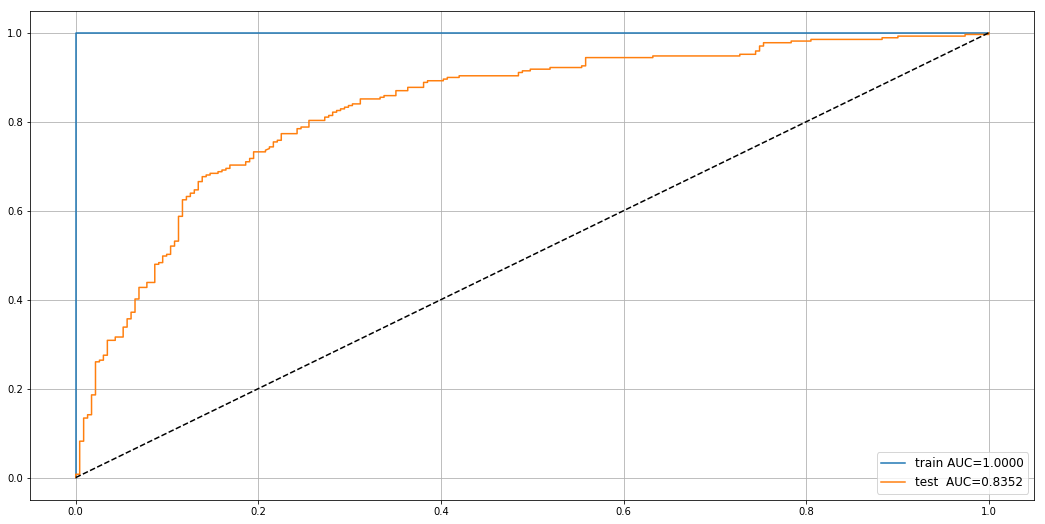

In [19]:
make_auc_plot(X_train_bow, X_test_bow, y_train, y_test, bow_model)

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

In [44]:
from sklearn.metrics import accuracy_score

# threshold for accuracy
threshold = 0.5

k_range = np.arange(10, 1000, 100)

train_auc_scores = []
test_auc_scores = []
train_accuracy_scores = []
test_accuracy_scores = []


for k in tqdm_notebook(k_range):
    bow_vocabulary = k_most_freq(bow_vocabulary_main, k)
    X_train_bow = np.stack(list(map(text_to_bow(bow_vocabulary), texts_train)))
    X_test_bow = np.stack(list(map(text_to_bow(bow_vocabulary), texts_test)))
    bow_model.fit(X_train_bow, y_train)
    
    proba_train = bow_model.predict_proba(X_train_bow)[:, 1]
    train_auc_scores.append(roc_auc_score(y_train, proba_train))
    train_pred = list(map(lambda x: 1 if x > threshold else 0, proba_train))
    train_accuracy_scores.append(accuracy_score(y_train, train_pred))
    
    proba_test = bow_model.predict_proba(X_test_bow)[:, 1]
    test_auc_scores.append(roc_auc_score(y_test, proba_test))
    test_pred = list(map(lambda x: 1 if x > threshold else 0, proba_test))
    test_accuracy_scores.append(accuracy_score(y_test, test_pred))

In [63]:
def plot_scores(k_range, train_scores, test_scores, title,
                train_label, test_label, xlabel, ylabel,
                figsize=(18,9), label_fontsize=16, 
                legend_fontsize=12, title_fontsize=20,
                linewidth=3, draw_grid=True):
    plt.figure(figsize=figsize)

    plt.plot(k_range, train_scores, linewidth=linewidth, label=train_label)
    plt.plot(k_range, test_scores, linewidth=linewidth, label=test_label)

    plt.title(title, fontsize=title_fontsize)
    plt.xlabel(xlabel, fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)

    plt.legend(fontsize=legend_fontsize, loc='best')
    if draw_grid:
        plt.grid()
    plt.show()

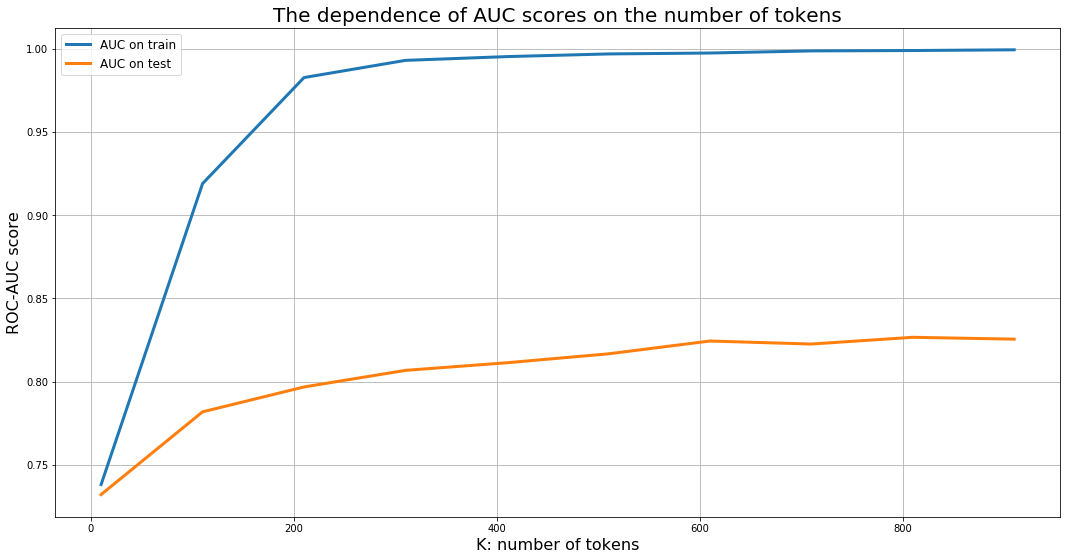

In [64]:
plot_scores(k_range, train_auc_scores, test_auc_scores,
            'The dependence of AUC scores on the number of tokens',
            'AUC on train', 'AUC on test', 'K: number of tokens',
            'ROC-AUC score')

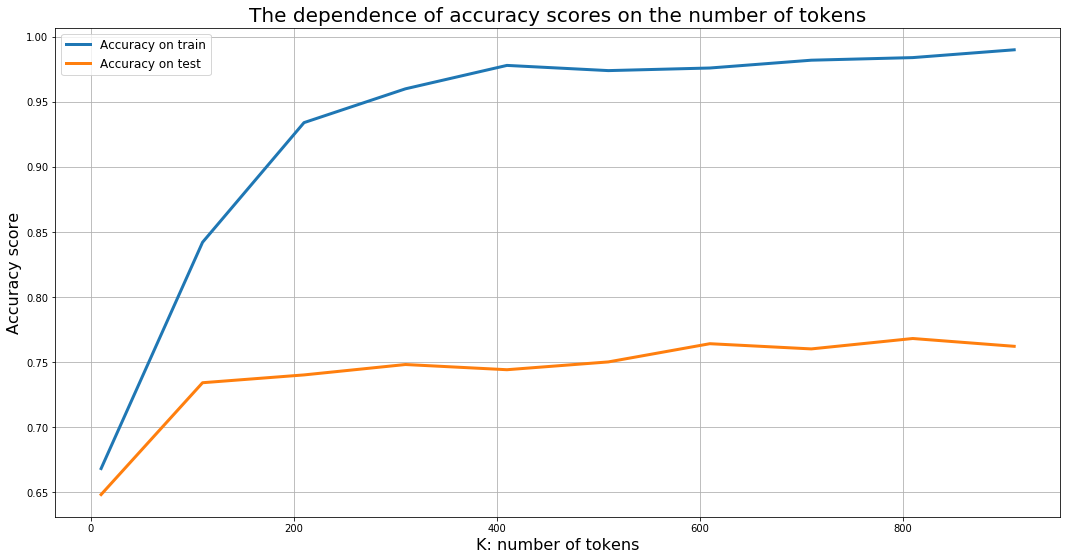

In [65]:
plot_scores(k_range, train_accuracy_scores, test_accuracy_scores,
            'The dependence of accuracy scores on the number of tokens',
            'Accuracy on train', 'Accuracy on test', 'K: number of tokens',
            'Accuracy score')

#### Task: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [68]:
def generate_idf(texts, alpha = 1., use_tqdm=True):
    '''
    This function generates IDF for every word in dataset
    
    Parameters
    -------------------
    texts : an array of texts to make idf-score
    
    alpha : smoothing hyperparameter (typically 1)
    
    use_tqdm : show progress or not
    
    
    Returns
    -------------------
    idf : A tuple of arrays (list of words, idf-score for words)
    
    It is better than dict object, because it is more convenient to make calls on the index
    '''
    
    idf = dict()
    words_set = set(' '.join(texts).split())
    N = len(texts)

    if use_tqdm:
        word_set = tqdm_notebook(words_set)
    
    for word in word_set:
        count = 0
        for document in texts_train:
            if word in document.strip().split():
                count += 1
        idf[word] = np.log((float(N) / (count + alpha)))
    
    return (list(idf.keys()), list(idf.values()))

In [69]:
idf = generate_idf(texts_train)

In [81]:
def _text_to_tf_idf(idf, text):
    '''
    This function generates tf_idf score for every word in text
    
    Parameters
    -------------------
    idf : A tuple of arrays (list of words, idf-score for words). Generated from `generate_idf` function
   
    text : An array. For each word of this array a tf_idf will be generated
    
    Returns
    -------------------
    tf_idf : An numpy.ndarray with tf_idf scores. Shape is (len(idf), )
    '''
    
    tokenized_text = text.strip().split()
    num_tokens = len(tokenized_text)
    tf_idf = np.zeros(len(idf[0]), dtype='float32')
    
    for i, word in enumerate(idf[0]):
        tf = tokenized_text.count(word) / num_tokens
        tf_idf[i] = tf * idf[1][i]
    return tf_idf

def text_to_tf_idf(idf):
    return lambda text : _text_to_tf_idf(idf, text)

In [82]:
X_train_tf_idf = np.stack(list(map(text_to_tf_idf(idf), texts_train)))
X_test_tf_idf = np.stack(list(map(text_to_tf_idf(idf), texts_test)))

In [91]:
# Normalize data samples
# I've tried different approaches, and MinMaxScaler works the best way
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_tf_idf_scaled = scaler.fit_transform(X_train_tf_idf)
X_test_tf_idf_scaled = scaler.transform(X_test_tf_idf)

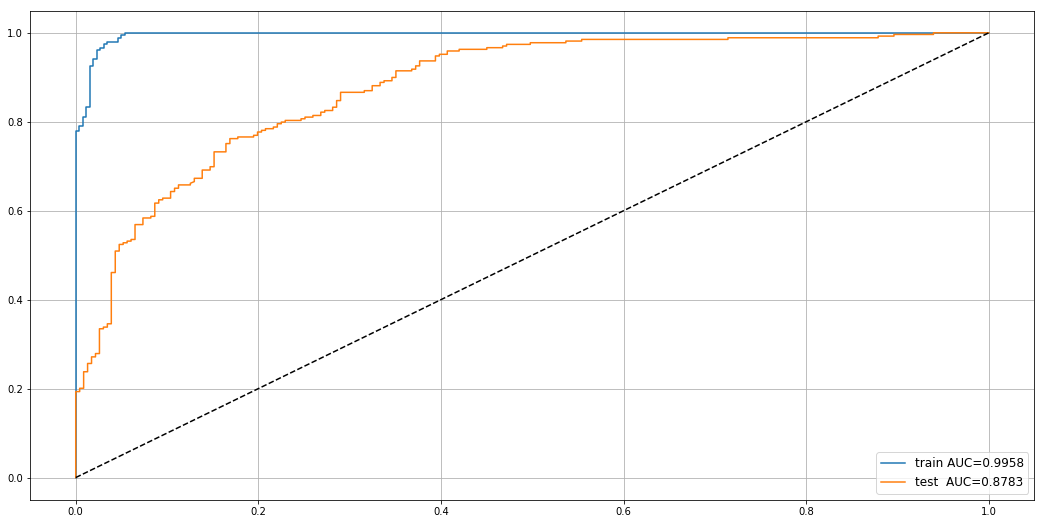

In [92]:
tf_idf_model = LogisticRegression(solver='liblinear').fit(X_train_tf_idf, y_train)
make_auc_plot(X_train_tf_idf_scaled, X_test_tf_idf_scaled, y_train, y_test, tf_idf_model)

**Conclusion**

Tf-idf works better, than simple bag of word.

It doesn't get 1. AUC score on train (but quite close), but it gets better results on test

### Part 2: gradient boosting (4 points)

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Download it and place in `data/` folder in the same directory as this notebook. There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

First you are required to choose one of the main gradient boosting frameworks:
1. LightGBM by Microsoft. [Link to github](https://github.com/Microsoft/LightGBM). One of the most popular frameworks these days that shows both great quality and performance.
2. xgboost by dlmc. [Link to github](https://github.com/dmlc/xgboost). The most famous framework which got very popular on kaggle.
3. Catboost by Yandex. [Link to github](https://github.com/catboost/catboost). Novel framework by Yandex company tuned to deal well with categorical features. It's quite new, but if you wish to use it - you are welcome.

Some simple preprocessing is done for you. 

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 85% accuracy on test dataset.

In [93]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [94]:
X_train = np.genfromtxt('data/train/X_train.txt')
y_train = np.genfromtxt('data/train/y_train.txt')

X_test = np.genfromtxt('data/test/X_test.txt')
y_test = np.genfromtxt('data/test/y_test.txt')

with open('data/activity_labels.txt', 'r') as iofile:
    activity_labels = iofile.readlines()

activity_labels = [x.replace('\n', '').split(' ') for x in activity_labels]
activity_labels = dict([(int(x[0]), x[1]) for x in activity_labels])

In [95]:
activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [96]:
print(X_train.shape)
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean)/data_std
X_test = (X_test - data_mean)/data_std

(7352, 561)


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [97]:
unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)
X_train_unique = X_train[:, unique_columns]
X_test_unique = X_test[:, unique_columns]

PCA could be useful in this case. E.g.

In [98]:
pca = PCA(0.99)

In [99]:
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

In [100]:
X_train_pca.shape

(7352, 179)

In [101]:
X_test_pca.shape

(2947, 179)

Text(0, 0.5, 'Principal component 2')

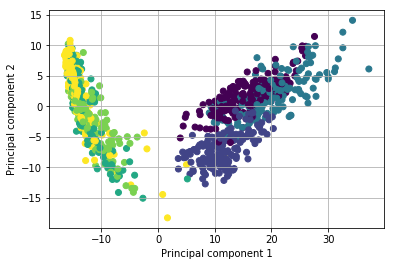

In [102]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

Text(0, 0.5, 'Principal component 5')

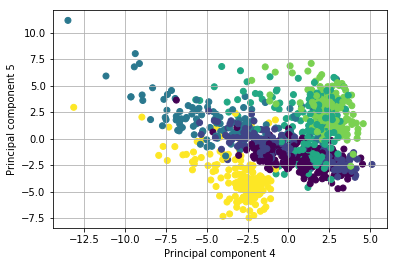

In [103]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 4')
plt.ylabel('Principal component 5')

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to use grid/random search (or any other approach) to approximate them by yourself.

In [104]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV


xgb_clf = XGBClassifier()
# There is no need to use any scaler, because data has been scaled already.
# But still, let's keep the pipeline, despite the fact, we have preprocessed data
pipeline = Pipeline([
    ('clf', xgb_clf)
])

In [105]:
rgrid = {
    'clf__max_depth': np.arange(2, 7),
    'clf__learning_rate': np.linspace(0.01, 0.2, 5),
    'clf__n_estimators': np.arange(100, 700, 100),
    'clf__gamma': np.linspace(0., 3., 10),
    'clf__min_child_weight': np.arange(1, 9),
}

rscv = RandomizedSearchCV(pipeline, rgrid, cv=3, n_jobs=-1, verbose=5)

rscv.fit(X_train_pca, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed: 12.0min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 16.6min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('clf', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'clf__max_depth': array([2, 3, 4, 5, 6]), 'clf__learning_rate': array([0.01  , 0.0575, 0.105 , 0.1525, 0.2   ]), 'clf__n_estimators': array([100, 200, 300, 400, 500, 600]), 'clf__gamma': array([0.     , 0.33333, 0.66667, 1.     , 1.33333, 1.66667, 2.     ,
       2.33333, 2.66667, 3.     ]), 'clf__min_child_weight': array([1, 2, 3, 4, 5, 6, 7, 8])},
          pre_dispatch='2*n_jobs', random_st

In [107]:
best_xgb_clf = rscv.best_estimator_timator_

predictions_train = best_xgb_clf.predict(X_train_pca)
train_accuracy = accuracy_score(y_train, predictions_train)

predictions_test = best_xgb_clf.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, predictions_test)

print("Accuracy score on train : {}".format(train_accuracy))
print("Accuracy score on test : {}".format(test_accuracy))

ACcuracy score on train : 1.0
Accuracy score on test : 0.9250084832032576


In [116]:
print("Best parameters for xgbClassifier model:")
for key in rscv.best_params_:
    print("{:<20} : {}".format(key[5:], rscv.best_params_[key]))

Best parameters for xgbClassifier model:
n_estimators         : 200
min_child_weight     : 6
max_depth            : 4
learning_rate        : 0.2
gamma                : 0.0


***Conclusion***

Achieved quite good accuracy score just by searching parameters for xgbClassifier. Not the hardest task :)

In [ ]:
### Example: https://rpubs.com/burakh/har_xgb